In [129]:
%env CUDA_VISIBLE_DEVICES=0
from es_map import qdax_task

import numpy as np
import brax
from brax import jumpy as jp
from brax.envs import env
import jax.numpy as jnp
import jax

import matplotlib.pyplot as plt


from brax.envs import wrappers
from brax.io import html
from brax import envs

from IPython.display import HTML, clear_output

env: CUDA_VISIBLE_DEVICES=0


In [130]:
from es_map import behavior_map
from es_map import map_elite_utils
from es_map import jax_evaluate

In [131]:
key = jax.random.PRNGKey(777)
key_envs = jax.random.split(key, 1)

In [4]:
run_path = "/scratch/ak1774/runs/large_files_jax/run-20220303_085708-pk4loduh"
import json
with open(run_path+'/config.json') as f:
    config = json.load(f)

In [5]:
config["BMAP_type_and_metrics"] = {
    "type" : "single_map",
    "metrics" : ["eval_fitness"],
}


In [6]:
#bds = np.random.randn(10000,2)
#fitnesses = np.random.randn(10000)
#novelties = np.random.randn(10000)

b_archive = [jnp.array(np.random.randn(2))]
b_archive = jnp.stack(b_archive)

bds = jnp.array(np.random.randn(10000,2))
fitnesses = jnp.array(np.random.randn(10000))
novelties = jnp.array(np.random.randn(10000))

In [13]:
new_individual = {
    "params" : None, # this would be theta + the a row from the noise generated by seed,
                     # I dont think we need to store this for now
    "child_eval" : {
        "perturbation_random_seed" : 0,
        "fitnesses" : fitnesses, # this is a jax array now, i think
        "bds" : bds,             # this is a jax array now
    },
    "eval_fitness" : 2.2,
    "eval_bc" : np.array([0,0])
}

config["env_name"] = "humanoid"
config["map_elites_grid_description"] = jax_evaluate.brax_get_bc_descriptor_for_env(config["env_name"])

b_map_cumm = behavior_map.create_b_map_grid(config)

In [14]:
map_elite_utils.try_insert_individual_in_map(new_individual,b_map_cumm,b_archive,config)

True

In [16]:
b_map_cumm.get_cell_coords(new_individual["eval_bc"])

(0, 0)

In [15]:

# note that we olny do this with fitness maps, no need to recalculate innovation or stuff like that
# note that instead of sampling children, we just use the children used for calculating the grad
# we can do this because evaluating once is fine if env is deterministic
def test_elite_mapping_performance(b_map_cumm,child_fitness,child_bds,config):
    
    b_map = behavior_map.create_b_map_grid(config)
    
    fitnesses = np.array(child_fitness)
    bds = np.array(child_bds)
    
    b_map_fillup_data = []
    b_map_cumm_fillup_data = []
    b_map_current_count = 0
    b_map_cumm_current_count = np.sum(b_map_cumm.data != None)
    
    for i in range(child_fitness.shape[0]):
        
        individual = {
                "eval_fitness" : fitnesses[i],
                "eval_bc" : bds[i],
        }
        
        b_map_added = map_elite_utils.try_insert_individual_in_map(individual,b_map,b_archive=None,config=config)
        b_map_cumm_added = map_elite_utils.try_insert_individual_in_map(individual,b_map_cumm,b_archive=None,config=config)
        b_map_current_count += int(b_map_added) 
        b_map_cumm_current_count += int(b_map_cumm_added) 
        b_map_fillup_data.append(b_map_current_count)
        b_map_cumm_fillup_data.append(b_map_cumm_current_count)
        
    # Now calculate the QD scores and nonempty ratios for both the cummulative and fresh map
    non_empty_cells = b_map.get_non_empty_cells()
    qd_score = np.sum([cell["elite"]["eval_fitness"] for cell in non_empty_cells])
    cumm_non_empty_cells = b_map_cumm.get_non_empty_cells()
    cumm_qd_score = np.sum([cell["elite"]["eval_fitness"] for cell in cumm_non_empty_cells])
    
    # also do some plots
    fig_f,ax = map_elite_utils.plot_b_map(b_map,metric="eval_fitness",config=config)
    fig_f_cumm,ax = map_elite_utils.plot_b_map(b_map_cumm,metric="eval_fitness",config=config)             
    
    # also plot how fast they accumulate
    b_map_fillup_data = np.array(b_map_fillup_data) / float(b_map.data.size)
    b_map_cumm_fillup_data = np.array(b_map_cumm_fillup_data) / float(b_map.data.size)
    fig_accumulation,ax = plt.subplots()
    ax.plot(b_map_fillup_data)
    ax.plot(b_map_cumm_fillup_data)
    
    results = {
        "nonempty_cells" : len(non_empty_cells),
        "nonempty_ratio" : float(len(non_empty_cells)) / b_map.data.size,
        "qd_score" : qd_score,
        "cumm_nonempty_cells" : len(cumm_non_empty_cells),
        "cumm_nonempty_ratio" : float(len(cumm_non_empty_cells)) / b_map_cumm.data.size,
        "cumm_qd_score" : cumm_qd_score,
        "b_map_plot" : fig_f,
        "b_map_cumm_plot" : fig_f_cumm,
        "b_map_accumulation_plot" : fig_accumulation,
    }
    return results
    

CPU times: user 336 ms, sys: 0 ns, total: 336 ms
Wall time: 334 ms


{'nonempty_cells': 769,
 'nonempty_ratio': 0.5933641975308642,
 'qd_score': 697.3094,
 'cumm_nonempty_cells': 769,
 'cumm_nonempty_ratio': 0.5933641975308642,
 'cumm_qd_score': 697.3094,
 'b_map_plot': <Figure size 432x288 with 1 Axes>,
 'b_map_cumm_plot': <Figure size 432x288 with 1 Axes>,
 'b_map_accumulation_plot': <Figure size 432x288 with 1 Axes>}

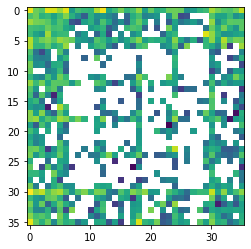

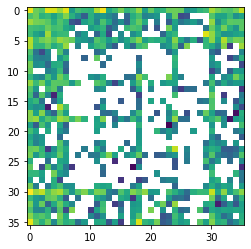

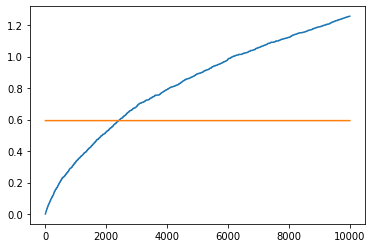

In [17]:
%%time
test_elite_mapping_performance(b_map_cumm,fitnesses,bds,config)

In [7]:

# for the sampling filling part i want to try inserting all the children
# In this notebook i will test how fast that code is, weather it is going to be a bottleneck to insert 10k into the map

# I also have to rethink what I store in the map
# I dont need to store the perturabtions, or random indicies, i can just store the jax random key
# A cell in the old version looks like this:
"params" : updated_theta,  # 1d torch tensor containing the parameters 
"ID" : get_next_individual_id(),
"parent_ID" : current_individual["ID"],
"generation_created" : generation_number,

"child_eval" : {
    "noise_descriptors" : pop_list,
    "fitnesses" : fitnesses,
    "bcs" : bcs,

    "child_obs_sum" : obs_sum,
    "child_obs_sq" : obs_sq,
    "child_obs_count" : obs_count,

    "batch_time" : batch_time,
}

"eval_fitness" : updated_eval_results["fitness"],
"eval_bc" : updated_eval_results["bc"],

"evolvability" : updated_evolvability,
"innovation" : updated_innovation,
"entropy" : updated_entropy,

"innovation_over_time" : {   # innovation decreases over time, as we add new individuals to the archive
    generation_number : updated_innovation,

    
    
# New cell looks like this:
{
    "params" : params, # np array
    "child_eval" : {
        "perturbation_random_seed" : seed,
        "fitnesses" : fitnesses,
        "bds" : bds,
    }
    "eval_fitness" : eval_fitness,
    "eval_bc" : eval_bc,
    
    "evolvability" : updated_evolvability,
    "innovation" : updated_innovation,
    "entropy" : updated_entropy,
    
    "innovation_calculated_at_generation" : 5,
    
    "innovation_over_time" : {   # innovation decreases over time, as we add new individuals to the archive
        generation_number : updated_innovation,
    } # maybe also keep this
    
}

In [267]:
A_mean = 0.0
A_sigma = 2
A = A_mean + np.random.randn(50000)*A_sigma
A_pdf = scipy.stats.norm(loc=0,scale=2).pdf(A)
B_pdf = scipy.stats.norm(loc=3,scale=1).pdf(A)

p = B_pdf / A_pdf
p = p / np.sum(p)

sorted_indicies = np.argsort(-p)
selected_points = A[sorted_indicies[0:20000]]

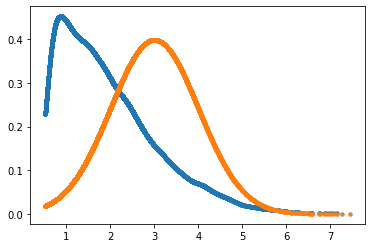

In [268]:
new_samples_kde = stats.gaussian_kde(selected_points).pdf(selected_points)
new_samples_true_prob = scipy.stats.norm(loc=3,scale=1).pdf(selected_points)
plt.plot(selected_points,new_samples_kde,".")
plt.plot(selected_points,new_samples_true_prob,".")

In [64]:
A_mean = 0.0
A_sigma = 2
A = A_mean + np.random.randn(50000)*A_sigma

In [65]:
A_pdf = scipy.stats.norm(loc=0,scale=2).pdf(A)
B_pdf = scipy.stats.norm(loc=3,scale=1).pdf(A)

p = B_pdf / A_pdf
p = p / np.sum(p)

new_samples = np.random.choice(A,size=2000, replace=True, p=p)
new_samples_kde = stats.gaussian_kde(new_samples).pdf(new_samples)
new_samples_true_prob = scipy.stats.norm(loc=3,scale=1).pdf(new_samples)

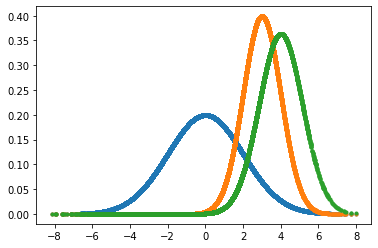

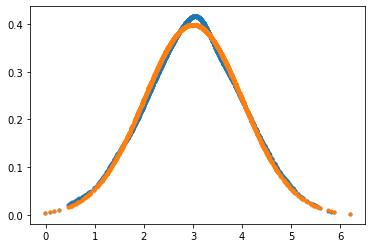

In [66]:
plt.plot(A,A_pdf,".")
plt.plot(A,B_pdf,".")
plt.plot(A,p*2000,".") # multiply with guestimate normalizing constant (which make area under the curve around 1)

plt.show()
plt.plot(new_samples,new_samples_kde,".")
plt.plot(new_samples,new_samples_true_prob,".")

In [51]:
# for each datapoint i need a probability
# this probability is a mix of the new distribution and the old
# i want the probability to be higher if the old is lower
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

A_mean = 0.0
A_sigma = 2
A = A_mean + np.random.randn(50000)*A_sigma

B_mean = 4
B_sigma = 1

A_prob = 1/(A_sigma*np.sqrt(2*np.pi)) * np.exp(  -1/2 * ((A - A_mean)/ A_sigma)**2)
B_prob = 1/(B_sigma*np.sqrt(2*np.pi)) * np.exp(  -1/2 * ((A - B_mean)/ B_sigma)**2)

A_prob = A_prob / np.sum(A_prob)
B_prob = B_prob / np.sum(B_prob)

p = B_prob/A_prob
p = p / np.sum(p)

new_samples = np.random.choice(A,size=2000, replace=True, p=p)
new_samples_kde = stats.gaussian_kde(new_samples).pdf(new_samples)

new_samples_true_prob = 1/(B_sigma*np.sqrt(2*np.pi)) * np.exp(  -1/2 * ((new_samples - B_mean)/ B_sigma)**2)

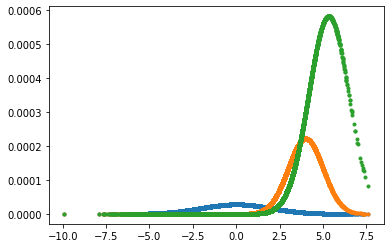

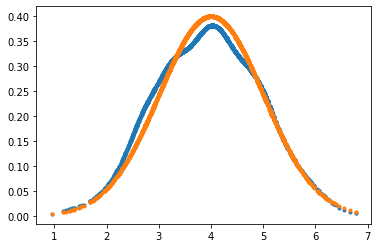

In [28]:
plt.plot(A,A_prob,".")
plt.plot(A,B_prob,".")
plt.plot(A,p,".")

plt.show()
plt.plot(new_samples,new_samples_kde,".")
plt.plot(new_samples,new_samples_true_prob,".")

In [79]:
new_samples = np.random.choice(orig_dist,size=2000, replace=True, p=new_sampling_prob)

In [80]:
import scipy
new_new_prob = scipy.stats.gaussian_kde(new_samples)
real_prob_new_new = 1/(new_sigma*np.sqrt(2*np.pi)) * np.exp(  -1/2 * ((new_samples - new_mean)/ new_sigma)**2)

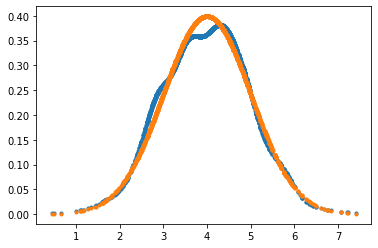

In [81]:
plt.plot(new_samples,new_new_prob.pdf(new_samples),".")
plt.plot(new_samples,real_prob_new_new,".")

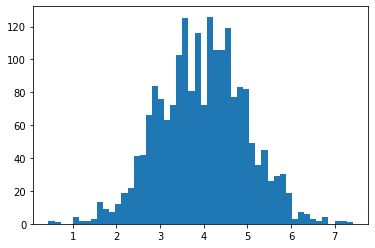

In [82]:
plt.hist(new_samples,bins=50);

In [84]:
# in order to do this, i need to calculate the distance between all the points, and all the centers

In [71]:
def calculate_prob(points,mean,sigma):
    distances = points-mean
    distances = jnp.sum(distances*distances, axis=1)
    prob = jnp.exp( -1/2 * ((distances)/sigma)**2)
    #prob = prob / jnp.sum(prob)
    return prob

batch_calculate_prob = jax.jit(jax.vmap(calculate_prob,in_axes=[None,0,None]))

In [72]:
def calcualte_prob_in_batches(common_perturbations,child_perturbations,sigma):
    batch_size = 50
    num_batches = int(np.ceil(child_perturbations.shape[0] / batch_size))
    results = []
    for i in range(num_batches):
        from_i = i*batch_size
        to_i = min((i+1)*batch_size,child_perturbations.shape[0])
        results.append(batch_calculate_prob(common_perturbations,child_perturbations[from_i:to_i],sigma))
    new_probs = jnp.concatenate(results,axis=0)
    
    return new_probs

In [79]:
orig_sigma = 2
child_sigma = 1
child_of_child_sigma = 1

common_perturbations = jax.random.normal(key=key,shape=[10000,600])*orig_sigma
perturbations = jax.random.normal(key=key,shape=[2000,600])*child_sigma



In [82]:
new_samples = np.random.choice(A,size=2000, replace=True, p=p)

DeviceArray([   0,    1,    2, ..., 9997, 9998, 9999], dtype=int32)

In [85]:

jax.random.choice(key=key, a=jnp.arange(10000), shape=(2000,), replace=True, p=p[0])


DeviceArray([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [83]:

# for each child, we want to select a subset of common_perturbations, so it has the child distribution 
# where the child distribution is defined by child_center and child_sigma

orig_prob = calculate_prob(common_perturbations,mean=jnp.zeros(600),sigma=orig_sigma)
#new_prob = calculate_prob(common_perturbations,mean=child_perturbations[0],sigma=child_sigma)   
new_probs = calcualte_prob_in_batches(common_perturbations,perturbations,sigma=child_sigma)

p = new_probs / orig_prob

    

In [118]:
distances = common_perturbations-jnp.zeros(600)
distances = jnp.sum(distances*distances, axis=1)/600
prob = jnp.exp( -1/2 * distances/(orig_sigma**2))
prob

DeviceArray([0.56670314, 0.59074175, 0.61684316, ..., 0.6135901 ,
             0.60571086, 0.6053263 ], dtype=float32)

(array([8.000e+00, 4.400e+01, 9.800e+01, 2.180e+02, 4.510e+02, 7.060e+02,
        1.060e+03, 1.353e+03, 1.542e+03, 1.463e+03, 1.194e+03, 8.560e+02,
        5.440e+02, 2.760e+02, 1.070e+02, 5.200e+01, 2.100e+01, 5.000e+00,
        1.000e+00, 1.000e+00]),
 array([0.5493304 , 0.5559253 , 0.56252027, 0.56911516, 0.57571006,
        0.58230495, 0.58889985, 0.5954948 , 0.6020897 , 0.6086846 ,
        0.61527956, 0.62187445, 0.62846935, 0.63506424, 0.64165914,
        0.6482541 , 0.654849  , 0.6614439 , 0.66803885, 0.67463374,
        0.68122864], dtype=float32),
 <a list of 20 Patch objects>)

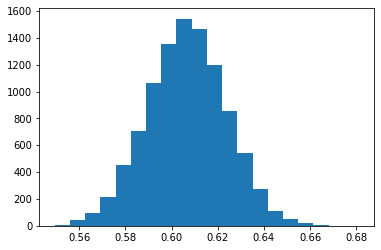

In [120]:
plt.hist(prob,bins=20)

In [101]:
distances

DeviceArray([2726.0146, 2526.6064, 2319.0742, ..., 2344.455 , 2406.492 ,
             2409.541 ], dtype=float32)

In [112]:
from scipy.stats import multivariate_normal
multivariate_normal.pdf(np.array(common_perturbations)*0.000000001, mean=np.zeros(600), cov=1)

array([3.51592411e-240, 3.51592411e-240, 3.51592411e-240, ...,
       3.51592411e-240, 3.51592411e-240, 3.51592411e-240])

In [216]:
dim = 1
A_sigma = 0.02
A_mean = np.zeros(dim)
B_sigma = 0.01
B_mean - np.random.randn(dim)*B_sigma

A = np.random.randn(1000,dim) * A_sigma + A_mean

array([-1.00000000e+000, -1.01152975e-015, -5.86636034e-105,
       -1.75572453e-152, -9.18212603e-167, -1.59017685e-187,
       -6.76755598e-217, -9.69732845e-229, -2.84182429e-231,
       -1.20278990e-240, -2.79424706e-257, -4.69843907e-263,
       -2.33228667e-273, -2.22411238e-284, -1.22422813e-288,
       -1.37380985e-292, -4.78278980e-304, -1.47408744e-316,
       -8.39911598e-323, -4.94065646e-324])

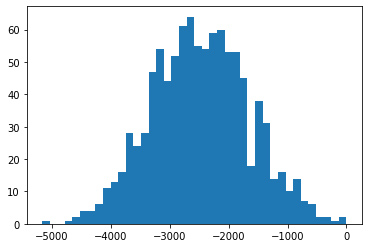

In [219]:
def logsumexp(x):
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))

A_distances = A-A_mean
A_distances = np.sum(A_distances*A_distances, axis=1)
A_exp_term = -1/2 * A_distances / (A_sigma**2)

B_distances = A-B_mean
B_distances = np.sum(B_distances*B_distances, axis=1)
B_exp_term = -1/2 * B_distances / (B_sigma**2)

exp_term = B_exp_term-A_exp_term

log_sum_prob = np.exp(exp_term - logsumexp(exp_term))
plt.hist(exp_term - logsumexp(exp_term),bins=40)
np.sort(-log_sum_prob)[0:20]


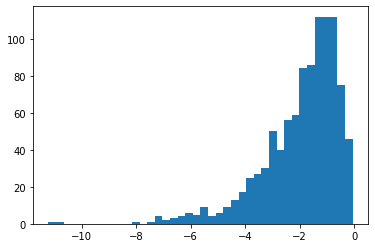

[-28.86487293 -30.49843755 -45.11210374 -69.8417132  -51.25837522]
[-2.08715764 -0.98760099 -3.31356705 -3.32089275 -1.01221657]
[-26.77771528 -29.51083657 -41.7985367  -66.52082045 -50.24615865]
probs
[2.34739414e-12 1.52618269e-13 7.03276590e-19 1.28936165e-29
 1.50789313e-22]
[2.34739414e-12 1.52618269e-13 7.03276590e-19 1.28936165e-29
 1.50789313e-22]
[3.86163569e-13 2.51068257e-14 1.15694162e-19 2.12109457e-30
 2.48059490e-23] 0.5125093457566783 1.0000000000000002
log_sum_prob  [3.86163569e-13 2.51068257e-14 1.15694162e-19 2.12109457e-30
 2.48059490e-23] 0.5125093457566782 1.0


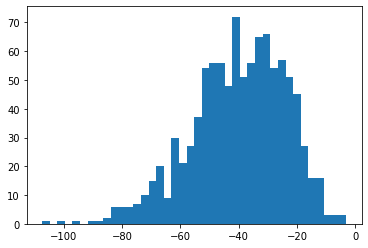

In [281]:
dim = 4
A_sigma = 2
A_mean = np.zeros(dim)
B_sigma = 1
B_mean - np.random.randn(dim)

A = np.random.randn(1000,dim) * A_sigma + A_mean

def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

def logsumexp(x):
    c = np.max(x)
    return c + np.log(np.sum(np.exp(x - c)))

def calculate_pdf_ratios(A,A_mean,A_sigma,B_mean,B_sigma):
    
    A_distances = A-A_mean
    A_distances = np.sum(A_distances*A_distances, axis=1)
    A_exp_term = -1/2 * A_distances / (A_sigma**2)
    
    B_distances = A-B_mean
    B_distances = np.sum(B_distances*B_distances, axis=1)
    B_exp_term = -1/2 * B_distances / (B_sigma**2)
    
    
    
    plt.hist(A_exp_term,bins=40)
    plt.show()
    plt.hist(B_exp_term,bins=40)
    
    
    exp_term = B_exp_term-A_exp_term
    max_exp_term = np.max(exp_term)
    
    normed_prob_B = np.exp(B_exp_term-max_exp_term)
    normed_prob_A = np.exp(A_exp_term-max_exp_term)
    normed_prob = normed_prob_B/normed_prob_A
    
    prob = np.exp(B_exp_term-A_exp_term)
    
    
    real_normalized_prob = exp_normalize(exp_term)
    
    log_sum_prob = np.exp(exp_term - logsumexp(exp_term))
    
    print(B_exp_term[0:5])
    print(A_exp_term[0:5])
    print((B_exp_term-A_exp_term)[0:5])
    print("probs")
    print(prob[0:5])
    print(normed_prob[0:5])
    print(real_normalized_prob[0:5],np.max(real_normalized_prob),np.sum(real_normalized_prob))
    print("log_sum_prob ",log_sum_prob[0:5],np.max(log_sum_prob),np.sum(log_sum_prob))
    
    
    return prob,normed_prob,real_normalized_prob,log_sum_prob
    
prob,normed_prob,real_normalized_prob,log_sum_prob = calculate_pdf_ratios(A,A_mean,A_sigma,B_mean,B_sigma)


<ipython-input-202-6cc7353495cf>:1: RuntimeWarning: divide by zero encountered in log
  plt.hist(np.log(log_sum_prob),bins=40)


ValueError: supplied range of [-inf, 0.0] is not finite

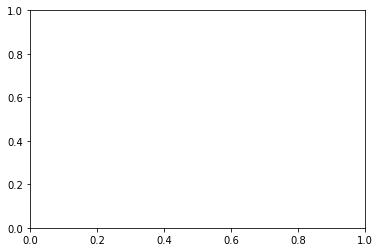

In [202]:
plt.hist(np.log(log_sum_prob),bins=40)

In [220]:
#np.sort(-log_sum_prob)

In [181]:
np.exp(-1000+100) / np.exp(-100+100)

0.0

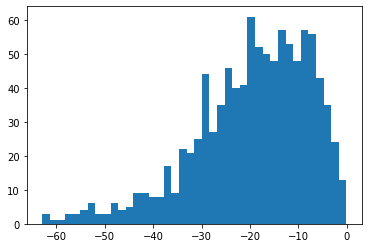

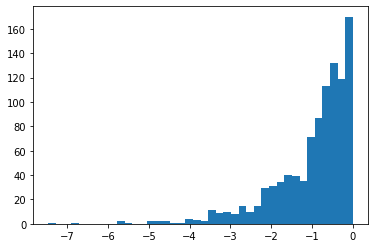

(array([ 3.,  0.,  2.,  4.,  6.,  5.,  4.,  5.,  5.,  5.,  6., 10.,  9.,
        12., 14., 14., 24., 24., 35., 41., 32., 40., 42., 53., 48., 58.,
        55., 47., 63., 46., 48., 54., 52., 46., 28., 24., 18.,  8.,  9.,
         1.]), array([-58.84089215, -57.23947866, -55.63806516, -54.03665167,
        -52.43523818, -50.83382469, -49.2324112 , -47.63099771,
        -46.02958422, -44.42817073, -42.82675724, -41.22534375,
        -39.62393026, -38.02251677, -36.42110328, -34.81968978,
        -33.21827629, -31.6168628 , -30.01544931, -28.41403582,
        -26.81262233, -25.21120884, -23.60979535, -22.00838186,
        -20.40696837, -18.80555488, -17.20414139, -15.60272789,
        -14.0013144 , -12.39990091, -10.79848742,  -9.19707393,
         -7.59566044,  -5.99424695,  -4.39283346,  -2.79141997,
         -1.19000648,   0.41140701,   2.0128205 ,   3.614234  ,
          5.21564749]), <a list of 40 Patch objects>)

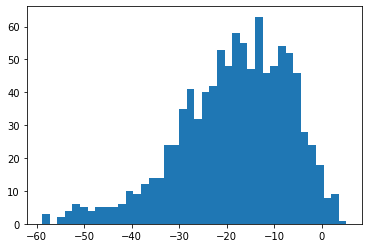

In [147]:
plt.hist(np.log(B_prob),bins=40)
plt.show()
plt.hist(np.log(A_prob),bins=40)
plt.show()
plt.hist(np.log(p),bins=40)

In [125]:

def exp_normalize(x):
    b = x.max()
    y = np.exp(x - b)
    return y / y.sum()

aa,b,c = [],[],[]

for dim in np.linspace(2,200,50):
    dim = int(dim)
    sigma = 1
    a = np.random.randn(100,dim)
    squared_dist = np.sum(a*a,axis=1)
    normed_squared_dist = squared_dist / dim
    prob = np.exp( -1/2 * squared_dist/(sigma**2))
    normed_prob = np.mean(np.exp( -1/2 * normed_squared_dist/(sigma**2)))
    mean_prob = np.mean(prob)
    
    exp_norm = np.mean(exp_normalize(-1/2 * squared_dist/(sigma**2)))

    aa.append(mean_prob)
    b.append(normed_prob)
    c.append(exp_norm)
    
    
    print(dim,mean_prob,normed_prob,exp_norm)



2 0.5396161096306715 0.6957535907902985 0.010000000000000002
6 0.1575980595227156 0.6499856286305602 0.01
10 0.02778634666375884 0.6198638213381881 0.01
14 0.0083321598778513 0.6309051843082043 0.01
18 0.002094368114754565 0.615134983331237 0.010000000000000002
22 0.0003835711815536982 0.6241147468890751 0.009999999999999998
26 4.3692513151371867e-05 0.6074344880368098 0.009999999999999998
30 2.7041121541592153e-05 0.621288835613316 0.01
34 7.899965208790787e-06 0.6079266723401411 0.01
38 5.853560085914478e-07 0.6125842557806106 0.009999999999999998
42 1.5883897580545697e-07 0.6188056725825934 0.009999999999999998
46 9.131373216871914e-07 0.6075287821831534 0.009999999999999995
50 5.773022009032317e-09 0.59665560720369 0.009999999999999998
54 1.4763917794396854e-09 0.6076022860416538 0.01
58 7.494237898280691e-10 0.6091771529683051 0.010000000000000002
62 7.688007803362088e-11 0.6173745340061937 0.009999999999999998
66 2.8840928736863463e-11 0.6091558453116179 0.01
70 7.917376335917629

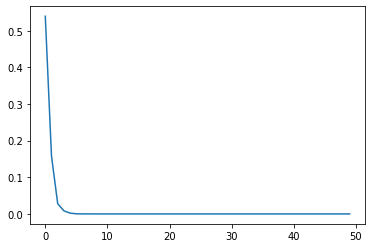

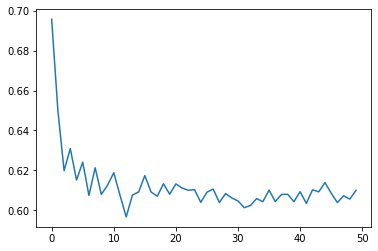

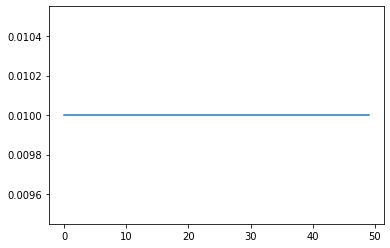

In [128]:
plt.plot(aa)
plt.show()
plt.plot(b)
plt.show()
plt.plot(c)
plt.show()

In [67]:
%%time
#new_probs = batch_calculate_prob(common_perturbations,perturbations,1)
batch_size = 50
num_batches = int(np.ceil(perturbations.shape[0] / batch_size))
results = []
for i in range(num_batches):
    from_i = i*batch_size
    to_i = min((i+1)*batch_size,perturbations.shape[0])
    results.append(batch_calculate_prob(common_perturbations,perturbations[from_i:to_i],1))
new_probs = jnp.concatenate(results,axis=0)



CPU times: user 121 ms, sys: 0 ns, total: 121 ms
Wall time: 11.6 s


In [29]:
a = jnp.ones([10,3])
sigma = 2
jnp.sum(a*a, axis=1)

 

#dist_fun = jax.vmap(calculate_distances,in_axes=[0,None,None])

DeviceArray([3., 3., 3., 3., 3., 3., 3., 3., 3., 3.], dtype=float32)

In [13]:
all_dist = dist_fun(perturbations,common_perturbations,offset)

RuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4800000000000 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:    2.68GiB
              constant allocation:         0B
        maybe_live_out allocation:    4.37TiB
     preallocated temp allocation:         0B
                 total allocation:    4.37TiB
              total fragmentation:         0B (0.00%)
Peak buffers:
	Buffer 1:
		Size: 4.37TiB
		Operator: op_name="jit(vmap(<lambda>))/jit(main)/sub" source_file="<ipython-input-12-4956a1e6acfa>" source_line=2
		XLA Label: fusion
		Shape: f32[2000,10000,60000]
		==========================

	Buffer 2:
		Size: 2.23GiB
		Entry Parameter Subshape: f32[10000,60000]
		==========================

	Buffer 3:
		Size: 457.76MiB
		Entry Parameter Subshape: f32[2000,60000]
		==========================



In [5]:
dist_squared = calculate_distances(perturbations[0],common_perturbations,offset)

In [8]:
dist_squared.shape

(10000, 60000)

In [14]:
2000*10000*60000

1200000000000

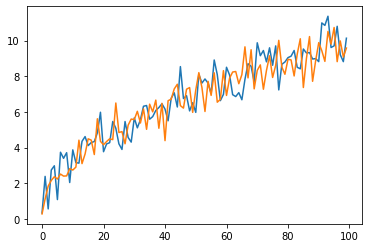

In [235]:
val = [np.sqrt(np.sum(np.random.randn(n+1)**2)) for n in range(100)]
val2 = [np.sqrt(np.sum(np.random.multivariate_normal(mean=np.zeros(n+1),cov=np.eye(n+1),size=1).reshape(-1)**2)) for n in range(100)]
plt.plot(val)
plt.plot(val2)

In [236]:
# what if instead of calculating a probability for randomly selecting, 
# we instead start adding points, which minimize error
# turn this into an optimization

In [ ]:
# we have 10k points
# we want to select 1k points from this, so it minimizes kde similarity to original dist
# how would we do that?

# we could 


In [ ]:
# what if each time i sampled, renormalize the probabilities again

In [239]:
exp_term = B_exp_term-A_exp_term

log_sum_prob = np.exp(exp_term - logsumexp(exp_term))

In [252]:
# what if i just sort it and select the top
# let us check the 1d case

array([-79662.56031261, -78594.57118981, -80462.11340721, -79605.5710505 ,
       -80475.43022792, -80606.27315887, -79434.06972265, -80835.00131722,
       -80615.73364512, -79627.42937909, -80401.11863618, -79609.01274321,
       -81667.5560204 , -78007.39496737, -80167.69480338, -79282.18313573,
       -80014.07421375, -81355.54392525, -81174.7280007 , -81396.67060085,
       -79364.2020253 , -79016.56468525, -79016.11065256, -79572.17256965,
       -80119.37727937, -78335.45438739, -80068.46125549, -78944.17965732,
       -80027.63189809, -79114.76651299, -80240.293856  , -79789.14857518,
       -79718.8741241 , -79447.90149883, -79360.05155729, -79257.41649232,
       -81411.59802195, -80070.36402138, -80845.49188991, -79842.79173309,
       -79701.41641071, -78907.14994967, -80883.73506269, -79954.77004323,
       -80378.02646219, -80129.13371899, -81348.91551512, -80154.13445811,
       -78355.18061296, -80681.20676893, -79259.28798163, -80950.77116434,
       -80770.10047447, -

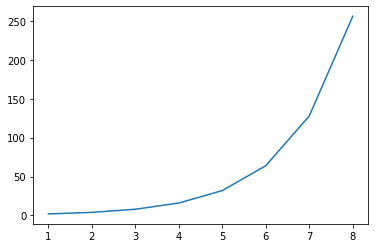

In [280]:
d = np.arange(8)+1
plt.plot(d,2**d)